In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from energy_model import *

In [2]:
path = 'energy_data/**.csv'
files = glob.glob(path)
files.sort()
files[:6]

['energy_data/arkansasnuclearone_energydata.csv',
 'energy_data/braidwoodgenerationstation_energydata.csv',
 'energy_data/brownsferry_energydata.csv',
 'energy_data/brunswicknuclear_energydata.csv',
 'energy_data/calvertcliffsnuclearpowerplant_energydata.csv',
 'energy_data/clintonpowerstation_energydata.csv']

In [3]:
r_values_dict = {}
rmse_values = np.zeros(len(files))
max_intake_rate = np.zeros(len(files))
max_energy_in = np.zeros(len(files))
max_discharge_rate = np.zeros(len(files))
pid = np.zeros(len(files))
for i,f in enumerate(files):
    plant_df = pd.read_csv(f, parse_dates=True, index_col='date')
    plant_id = plant_df['Plant ID'].values[0]
    print(f"Plant: {plant_id}")
    # preprocess
    plant_df = energy_to_kj(plant_df)
    plant_df = plant_df.resample('M').mean()
    
    idx = plant_df['max_discharge_temp_C'].argmax()
    max_intake_rate[i] = plant_df['withdrawal_rate_kgM'].values[idx]
    max_energy_in[i] = plant_df['elc_in_kj'].values[idx]
    max_discharge_rate[i] = plant_df['discharge_rate_kgM'].values[idx]
    pid[i] = plant_id
    # esimate R
    try:
        R, rmse = estimate_R_combined_gridsearch(plant_df, n_iter=100)
    except:
        print('Numerical error. Check dataset.')
        R = -2
        rmse = -2
    r_values_dict[plant_id] = R
    rmse_values[i] = rmse
    

Plant: 8055
Plant: 6022
Plant: 46
Plant: 6014
Plant: 6011
Plant: 204
Plant: 6145
Plant: 8036
Plant: 6099
Plant: 6000
Plant: 869
Plant: 3251
Plant: 8907
Plant: 6110
Plant: 6026
Plant: 6038
Plant: 566
Plant: 1922
Plant: 2589
Plant: 6168
Plant: 3265
Plant: 3166
Plant: 4046
Plant: 1925
Plant: 2410
Plant: 880
Plant: 6122
Plant: 6115
Plant: 6152
Plant: 6251
Numerical error. Check dataset.
Plant: 6045
Plant: 3806
Plant: 621
Numerical error. Check dataset.
Plant: 6127
Plant: 4270
Plant: 210
Numerical error. Check dataset.


In [4]:
max_values = pd.DataFrame({'max_intake_rate':max_intake_rate,
                           'max_discharge_rate':max_discharge_rate,
                           'max_energy_in_kj':max_energy_in,
                           'Plant ID':pid})
max_values.head()

,max_intake_rate,max_discharge_rate,max_energy_in_kj,Plant ID
0,6.731690e+10,6.641380e+10,1.490373e+13,8055.0
1,2.423809e+11,3.004786e+09,1.910417e+13,6022.0
2,3.269742e+11,3.265195e+11,2.545452e+13,46.0
3,8.790955e+10,8.790955e+10,1.519964e+13,6014.0
4,4.032976e+11,4.032976e+11,1.413216e+13,6011.0


In [5]:
r_df = pd.DataFrame({'R_combined':list(r_values_dict.values()),
                     'Plant ID':list(r_values_dict.keys()),
                     'RMSE':rmse_values})
r_df.head(3)

,R_combined,Plant ID,RMSE
0,0.635727,8055,10.931049
1,0.000000,6022,46983.820234
2,0.686182,46,2.072204


In [6]:
quality_rdf = r_df[(r_df.RMSE >= 0)&(r_df.RMSE < 5)].dropna().reset_index(drop=True)

In [7]:
plant_names = pd.read_csv('nuclear_plants_OT.csv')
plant_names.head()

,Plant Code,Nameplate Capacity (MW),Plant Name,State,max_withdrawal_rate_kgM
0,46.0,3494.0,Browns Ferry,AL,1979794.29
1,204.0,1138.3,Clinton Power Station,IL,610000.00
2,210.0,1267.7,Wolf Creek Generating Station,KS,500086.00
3,566.0,2162.9,Millstone,CT,1467229.09
4,621.0,1637.2,Turkey Point,FL,4803017.66


In [8]:
plant_names.rename(columns={'Plant Code':'Plant ID'},inplace=True)
plant_names['Plant ID'] = plant_names['Plant ID'].apply(int)
quality_rdf = quality_rdf.merge(plant_names, on='Plant ID')
quality_rdf.head()

,R_combined,Plant ID,RMSE,Nameplate Capacity (MW),Plant Name,State,max_withdrawal_rate_kgM
0,0.686182,46,2.072204,3494.0,Browns Ferry,AL,1979794.29
1,0.464182,6014,1.529303,2003.2,Brunswick Nuclear,NC,1047966.00
2,0.000000,6011,1.143258,1850.4,Calvert Cliffs Nuclear Power Plant,MD,2400349.09
3,0.333000,8036,3.579213,801.0,Cooper Nuclear Station,NE,668000.00
4,0.000000,6099,0.542665,2323.0,Diablo Canyon,CA,1734283.64


In [9]:
temp_limits = pd.DataFrame({'State':['OH','PA','NY','MI',
                                     'IL','IN','WI','MO',
                                     'IA','LA','GA','KY',
                                     'VA','AL','NC','MD',
                                     'NE','CA', 'CT', 'SC',
                                     'NH','FL'],
 'temp_limit':[32, 30.5, 32,np.nan,32+1.7, 
               32.2+2.8, 28.9+2.8, 32.2+2.8,
               30+1.7, 32.2+2.2, 32, 31.7, 
               32+1.7, 32, 32+2.8,32,29+2,
               20+11.1, 29.4, 32.2, np.nan,
               33.3],
 'limit_text':['32', '30.5', '32','unclear','32+1.7', 
               '32.2+2.8', '28.9+2.8', '32.2+2.8',
               '30+1.7', '32.2+2.2', '32', '31.7', 
               '32+1.7', '32',' 32+2.8','32','29+2',
               '20+11.1','29.4', '32.2','unclear', '33.3']})

In [10]:
quality_rdf = quality_rdf.merge(temp_limits, on='State', how='left')

In [11]:
frames = []
for f in files:
    plant_df = pd.read_csv(f, parse_dates=True, index_col='date')
    plant_id = plant_df['Plant ID'].values[0]
    if plant_id not in quality_rdf['Plant ID'].values:
        continue
    else:
        plant_df = energy_to_kj(plant_df)
        plant_df = plant_df.resample('M').mean()
        R = quality_rdf[quality_rdf['Plant ID'] == plant_id].R_combined.values[0]
        temp_limit = quality_rdf[quality_rdf['Plant ID'] == plant_id].temp_limit.values[0]
        plant_df['modeled_discharge_temp'] = calculate_discharge_temp_series(plant_df, R)
        plant_df['R_combined'] = R
        plant_df['temp_limit'] = temp_limit
#         plant_df['swt_threshold'] = calculate_temp_threshold_series(plant_df)
#         print(plant_id, plant_df[(plant_df.index.month > 5) & (plant_df.index.month < 9)]['swt_threshold'].mean())
        plant_df.to_csv(f'energy_balance/energy_balance_plant_{plant_id}.csv')
        
        plant_df.rename(columns={'avg_discharge_temp_C':f"avg_discharge_{plant_id}",
                                 'modeled_discharge_temp':f"modeled_discharge_{plant_id}"},
                        inplace=True)
        frames.append(plant_df[[f'avg_discharge_{plant_id}', f'modeled_discharge_{plant_id}']])
#         ax = plant_df[(plant_df.index.month > 5) & (plant_df.index.month < 9)].withdrawal_rate_kgM.plot()
#         plant_df[(plant_df.index.month > 5) & (plant_df.index.month < 9)].discharge_rate_kgM.plot(ax=ax,
#                                                                                                  linestyle='-.')
#         meanval = plant_df[(plant_df.index.month > 5) & (plant_df.index.month < 9)].withdrawal_rate_kgM.mean()
#         ax.axhline(meanval)
#         plt.show()
#         plant_df[[f'avg_discharge_{plant_id}', f'modeled_discharge_{plant_id}','swt_threshold']].plot()
#         plt.show()
estimate_df = pd.concat(frames, axis=1)

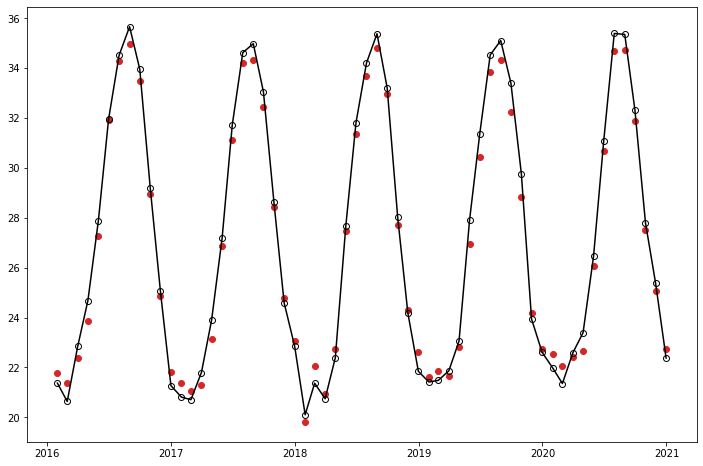

In [13]:
fig,ax=plt.subplots(figsize=(12,8))
y=(estimate_df.iloc[:,0::2].mean(axis=1))
ax.plot(y, color='k', marker='o', markerfacecolor='none')
y_p=(estimate_df.iloc[:,1::2].mean(axis=1))
ax.scatter(x=y_p.index, y=y_p.values, color='tab:red')
plt.show()

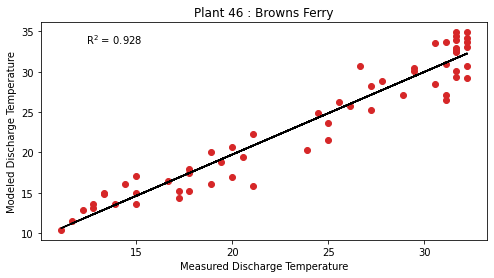

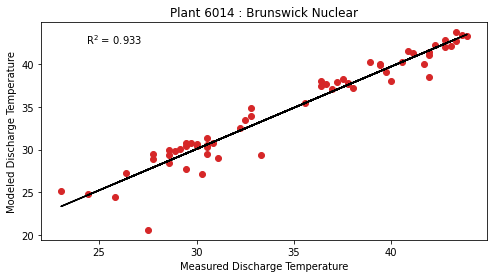

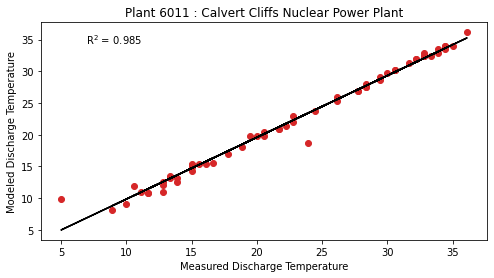

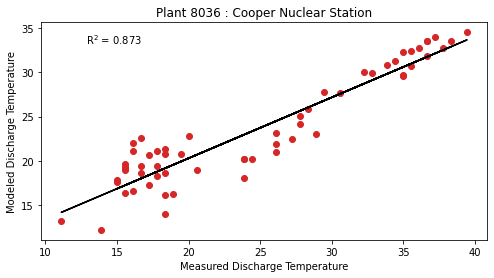

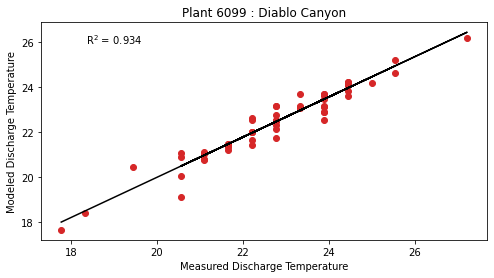

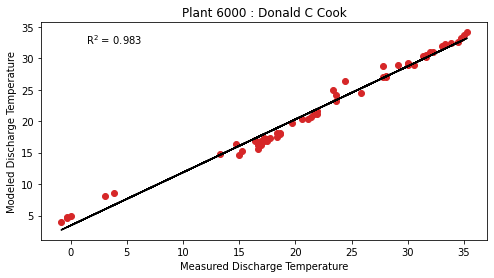

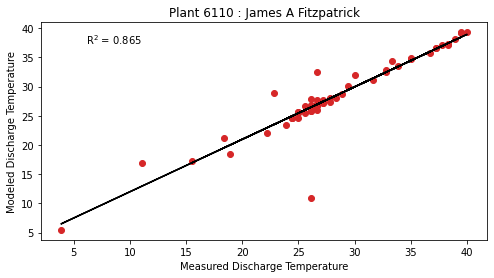

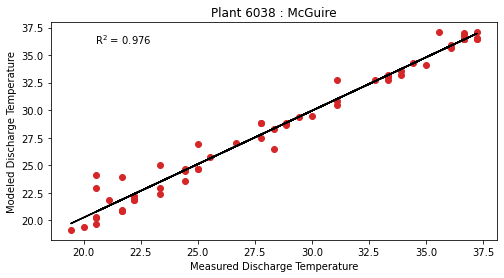

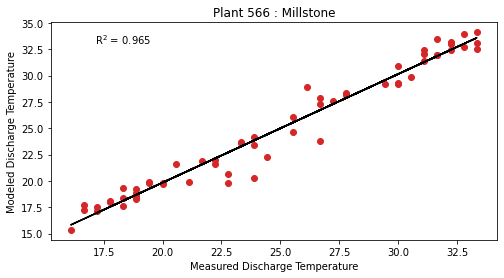

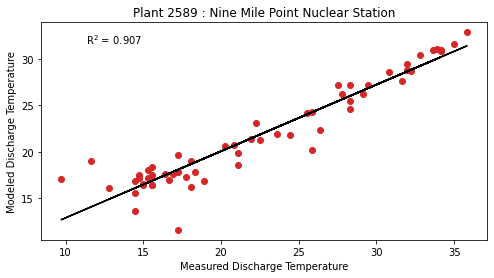

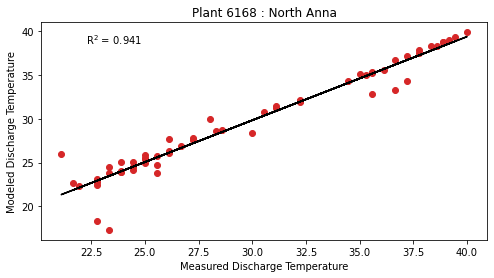

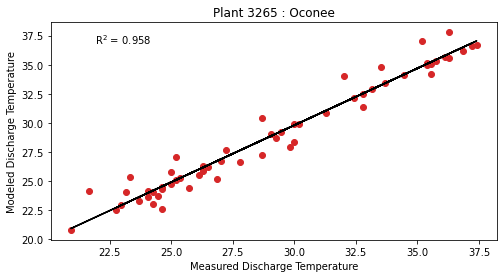

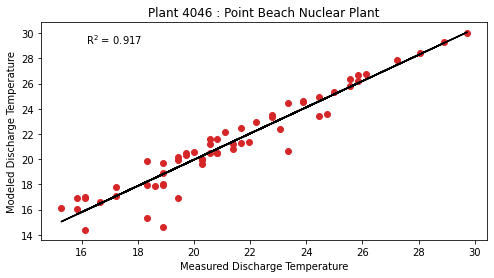

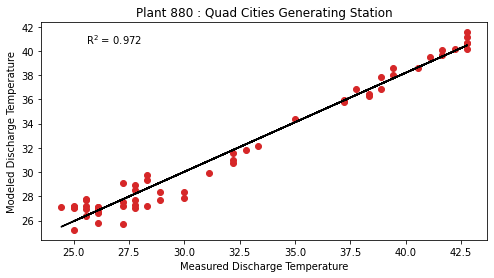

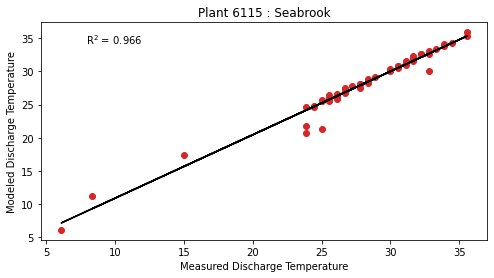

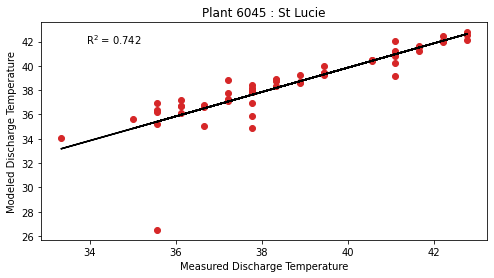

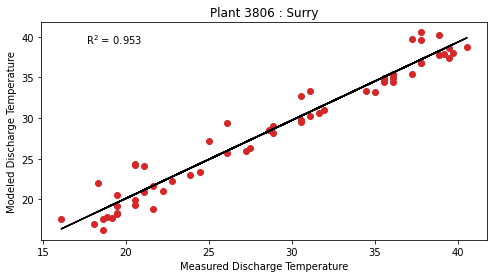

In [14]:
r_squared_list = np.zeros(len(quality_rdf))
max_intake_rate = np.zeros(len(quality_rdf))
max_energy_in = np.zeros(len(quality_rdf))
max_discharge_rate = np.zeros(len(quality_rdf))
for i in range(0,len(quality_rdf),1):
    plant_id = quality_rdf.loc[i,'Plant ID']
    plant_name = quality_rdf.loc[i,'Plant Name']
    fig,ax=plt.subplots(figsize=(8,4))
    df_i = estimate_df.iloc[:,2*i:2*i+2]
    model = linear_fit(df_i)
    y_pred=model.fittedvalues
    x_vals = df_i.iloc[:,0]
    y_true=df_i.iloc[:,1]
    r_squared = model.rsquared
    r_squared_list[i] = r_squared
    ax.scatter(x=x_vals, y=y_true, color='tab:red')
    ax.plot(x_vals, y_pred, color='k')
    ax.annotate(r'R$^2$ = {}'.format(round(r_squared,3)), xy=(.1, .9), xycoords=ax.transAxes)
    ax.set_title(f'Plant {plant_id} : {plant_name}')
    ax.set_xlabel('Measured Discharge Temperature')
    ax.set_ylabel('Modeled Discharge Temperature')
    plt.show()

In [15]:
quality_rdf['rsquared'] = r_squared_list
quality_rdf

,R_combined,Plant ID,RMSE,Nameplate Capacity (MW),Plant Name,State,max_withdrawal_rate_kgM,temp_limit,limit_text,rsquared
0,0.686182,46,2.072204,3494.0,Browns Ferry,AL,1979794.29,32.0,32,0.928341
1,0.464182,6014,1.529303,2003.2,Brunswick Nuclear,NC,1047966.00,34.8,32+2.8,0.933299
2,0.000000,6011,1.143258,1850.4,Calvert Cliffs Nuclear Power Plant,MD,2400349.09,32.0,32,0.985409
3,0.333000,8036,3.579213,801.0,Cooper Nuclear Station,NE,668000.00,31.0,29+2,0.872914
4,0.000000,6099,0.542665,2323.0,Diablo Canyon,CA,1734283.64,31.1,20+11.1,0.933871
5,0.534818,6000,1.791246,2285.3,Donald C Cook,MI,2761209.36,NaN,unclear,0.983473
6,0.100909,6110,2.487106,883.3,James A Fitzpatrick,NY,359962.60,32.0,32,0.864828
7,0.151364,6038,0.926776,2440.6,McGuire,NC,2032000.00,34.8,32+2.8,0.976256
8,0.474273,566,1.093864,2162.9,Millstone,CT,1467229.09,29.4,29.4,0.965335
9,0.716455,2589,2.748695,1901.1,Nine Mile Point Nuclear Station,NY,286205.96,32.0,32,0.907287


In [ ]:
quality_rdf.rename(columns={'rsquared':'discharge_rsquared'}, inplace=True)

In [ ]:
quality_rdf.describe()